In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import Callback
import catboost as cb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

In [45]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Prepare the data
X = train.drop('target', axis=1)
y = train['target']

In [46]:
# Define models
catboost_model = cb.CatBoostClassifier(
    iterations=700,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='AUC',
    od_type='Iter',
    od_wait=20,
    random_seed=42,
    verbose=False
)

xgboost_model = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=700,
    max_depth=6,
    random_state=42
)
svm_model = SVC(
    probability=True,
    random_state=42
)

logreg_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

In [47]:
# Train final models on full dataset
catboost_model.fit(X, y)
xgboost_model.fit(X, y)
rf_model.fit(X, y)
svm_model.fit(X, y)
logreg_model.fit(X, y)
pass

In [48]:
# add model predictions as features to the training and validation datasets
train['catboost_pred'] = catboost_model.predict_proba(X)[:, 1]
train['xgboost_pred'] = xgboost_model.predict_proba(X)[:, 1]
train['rf_pred'] = rf_model.predict_proba(X)[:, 1]
train['svm_pred'] = svm_model.predict_proba(X)[:, 1]
train['logreg_pred'] = logreg_model.predict_proba(X)[:, 1]

Test_X = test.copy()
# also add model predictions as features to the test dataset
test['catboost_pred'] = catboost_model.predict_proba(Test_X)[:, 1]
test['xgboost_pred'] = xgboost_model.predict_proba(Test_X)[:, 1]
test['rf_pred'] = rf_model.predict_proba(Test_X)[:, 1]
test['svm_pred'] = svm_model.predict_proba(Test_X)[:, 1]
test['logreg_pred'] = logreg_model.predict_proba(Test_X)[:, 1]

In [49]:
# Split the data
X = train.drop('target', axis=1)
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

test_scaled = scaler.transform(test)

In [50]:
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * (drop ** ((1 + epoch) // epochs_drop))
    return max(lr, 1e-7)  # Set a minimum learning rate

In [51]:
model = create_model(X_train.shape[1])
model.compile(optimizer=AdamW(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

In [53]:
# Custom callback for tqdm progress bar
class TqdmProgressCallback(Callback):
    def __init__(self, epochs):
        super().__init__()
        self.epochs = epochs
        self.progress_bar = None

    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(total=self.epochs, desc='Training')

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
        self.progress_bar.set_postfix({
            'loss': f"{logs['loss']:.4f}",
            'val_loss': f"{logs['val_loss']:.4f}",
            'accuracy': f"{logs['accuracy']:.4f}",
            'val_accuracy': f"{logs['val_accuracy']:.4f}"
        })

    def on_train_end(self, logs=None):
        self.progress_bar.close()


In [54]:
# Train the model
epochs = 200
tqdm_callback = TqdmProgressCallback(epochs)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=epochs,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler, tqdm_callback],
    verbose=0
)

Training:   0%|          | 0/200 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


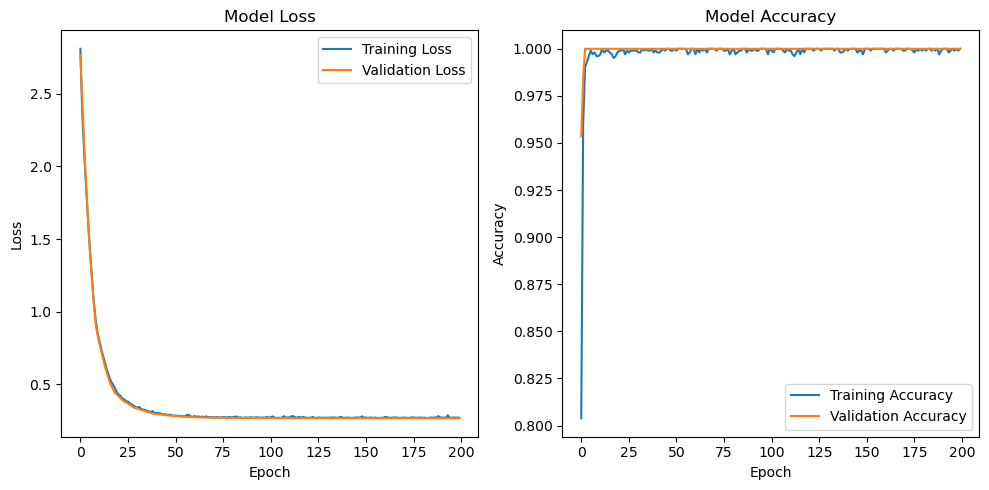

In [56]:
# Visualize the learning progress
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
# Evaluate the model
val_predictions = model.predict(X_val_scaled)
val_auc = roc_auc_score(y_val, val_predictions)
val_predictions_binary = (val_predictions > 0.5).astype(int)
val_accuracy = accuracy_score(y_val, val_predictions_binary)
print(f"Validation AUC: {val_auc}")
print(f"Validation Accuracy: {val_accuracy}")

# Make predictions on the test set
test_predictions = model.predict(test_scaled)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Save the binary predictions to a file
pd.DataFrame({'target': test_predictions_binary.flatten()}).to_csv('answers.csv', index=False)

# Optional: Print the distribution of predictions
unique, counts = np.unique(test_predictions_binary, return_counts=True)
print("\nDistribution of predictions:")
for value, count in zip(unique, counts):
    print(f"Class {value}: {count} ({count/len(test_predictions_binary)*100:.2f}%)")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation AUC: 1.0
Validation Accuracy: 1.0
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step

Distribution of predictions:
Class 0: 171 (39.77%)
Class 1: 259 (60.23%)
